In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, FloatSlider, Layout
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm

In [2]:
def simulate_heston_paths(S0=100, v0=0.04, kappa=2, theta=0.04, xi=0.3, rho=-0.7,
                          r=0.02, T=1, N=252, paths=50):
    dt = T/N
    S = np.zeros((paths, N+1)); S[:, 0] = S0
    v = np.zeros((paths, N+1)); v[:, 0] = v0
    z1 = np.random.standard_normal((paths, N))
    z2 = rho*z1 + np.sqrt(1-rho**2)*np.random.standard_normal((paths, N))
    for t in range(N):
        sv = np.sqrt(np.clip(v[:, t], 0, None)*dt)
        S[:, t+1] = S[:, t] * np.exp((r - 0.5*np.clip(v[:, t],0,None))*dt + sv*z1[:, t])
        v[:, t+1] = np.clip(v[:, t] + kappa*(theta - v[:, t])*dt + xi*sv*z2[:, t], 0, None)
    return S, v


def plot_heston_barrier(n_paths=50, barrier=120, strike=100):
    # dark colors
    bg      = "#1e1e1e"
    fg      = "#d4d4d4"
    gridcol = "#2a2a2a"

    plt.rcParams.update({
        "figure.facecolor": bg,
        "axes.facecolor": bg,
        "axes.edgecolor": fg,
        "axes.labelcolor": fg,
        "xtick.color": fg,
        "ytick.color": fg,
        "text.color": fg,
        "grid.color": gridcol,
        "grid.alpha": 0.5,
        "savefig.facecolor": bg,
        "figure.dpi": 120,
    })

    S, v = simulate_heston_paths(paths=n_paths)
    t = np.linspace(0, 1, S.shape[1])
    hit = (S.max(axis=1) >= barrier)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), gridspec_kw={'height_ratios': [3, 1]})

    # price paths
    for i in range(n_paths):
        col = (0.75, 0.75, 0.75, 0.28) if not hit[i] else (0.6, 1.0, 0.6, 0.6)
        ax1.plot(t, S[i], lw=1, color=col, antialiased=True)

    ax1.axhline(barrier, color="#ff4d4d", linestyle="--", lw=2, label="Barrier")   # red dashed
    ax1.axhline(strike,  color="#ffd447", linestyle=":",  lw=2, label="Strike")    # yellow dotted
    ax1.set_title("Heston — Up-and-In (paths colored if barrier hit)")
    ax1.set_ylabel("Stock Price")
    ax1.grid(True)
    ax1.legend(loc="upper left", frameon=False)

    # vol paths
    for i in range(n_paths):
        ax2.plot(t, np.sqrt(v[i])*100, lw=1, alpha=0.35, color="#00e5ff", antialiased=True)  # cyan
    ax2.set_xlabel("Time (years)")
    ax2.set_ylabel("Vol (%)")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# --- 3 sliders ---
paths_slider  = widgets.IntSlider(value=50, min=10, max=200, step=10, description="Paths", layout=widgets.Layout(width='420px'))
barrier_slider= widgets.IntSlider(value=120, min=80, max=200, step=5, description="Barrier", layout=widgets.Layout(width='420px'))
strike_slider = widgets.IntSlider(value=100, min=60, max=150, step=5, description="Strike", layout=widgets.Layout(width='420px'))

ui = widgets.HBox([paths_slider, barrier_slider, strike_slider])
out = widgets.interactive_output(
    plot_heston_barrier,
    {"n_paths": paths_slider, "barrier": barrier_slider, "strike": strike_slider}
)

display(ui, out)



Output()

# Example: Barrier Options

A knock-out barrier option requires the price path to *not* hit a certain price threshold (during the entire path) otherwise the payoff is zero.

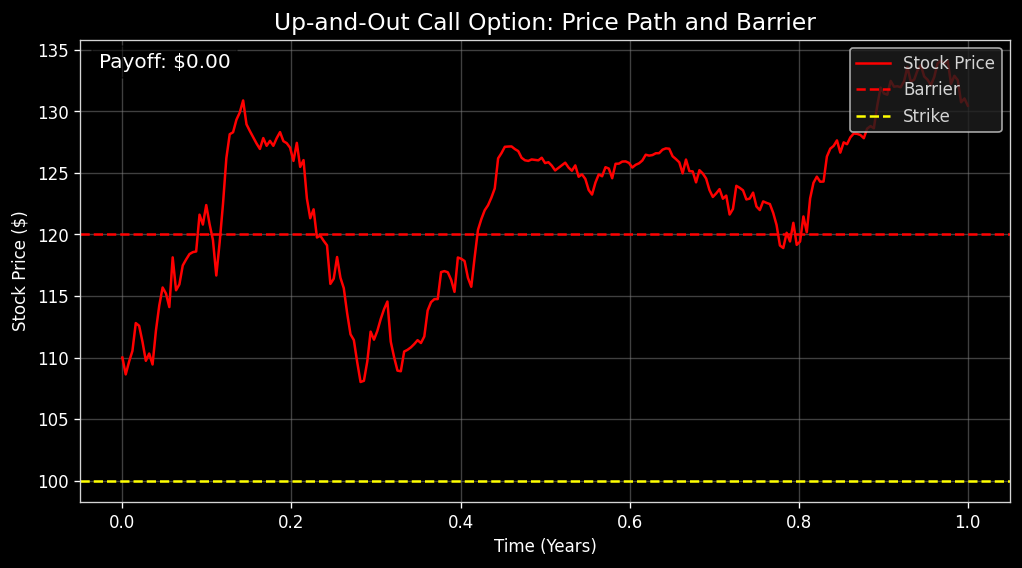

In [3]:
def simulate_heston_path(S0, v0, kappa, theta, xi, rho, r, T, N):
    dt = T/N
    S = np.zeros(N+1)
    v = np.zeros(N+1)
    S[0] = S0
    v[0] = v0
    
    for i in range(N):
        z1 = np.random.normal()
        z2 = rho * z1 + np.sqrt(1-rho**2) * np.random.normal()
        
        v[i+1] = v[i] + kappa*(theta-v[i])*dt + xi*np.sqrt(max(v[i],0)*dt)*z2
        v[i+1] = max(0, v[i+1])  # Ensure variance stays positive
        
        S[i+1] = S[i] * np.exp((r - 0.5*v[i])*dt + np.sqrt(max(v[i],0)*dt)*z1)
    
    return S, v

# Parameters
S0 = 110 # Initial stock price
v0 = 0.04 # Initial variance
kappa = 2.0
theta = 0.04
xi = 0.4 # Volatility of variance
rho = -0.5
r = 0.02
T = 1.0
N = 252 # Number of steps
K = 100
B = 120 # Barrier level

# Simulate path
S, v = simulate_heston_path(S0, v0, kappa, theta, xi, rho, r, T, N)
t = np.linspace(0, T, N+1)

# Check if barrier was hit
barrier_hit = np.any(S >= B)
if barrier_hit:
    path_color = 'red'
else:
    path_color = 'green' if S[-1] > K else 'yellow'

# Create the payoff
payoff = max(S[-1] - K, 0) if not barrier_hit else 0



# Plot
plt.figure(figsize=(10,5))
plt.plot(t, S, label="Stock Price", color=path_color)
plt.axhline(y=B, color='red', linestyle='--', label="Barrier")
plt.axhline(y=K, color='yellow', linestyle='--', label="Strike")

plt.title("Up-and-Out Call Option: Price Path and Barrier", fontsize=14, color="white")
plt.xlabel("Time (Years)", color="white")
plt.ylabel("Stock Price ($)", color="white")
plt.legend(loc="upper right")


# Background
plt.gca().set_facecolor("black")
plt.gcf().patch.set_facecolor("black")
plt.grid(True, color="gray")

plt.tick_params(colors="white")
plt.text(0.02, 0.94, f"Payoff: ${payoff:.2f}", transform=plt.gca().transAxes,
         fontsize=12, color="white", bbox=dict(facecolor="black", alpha=0.5))

plt.show()


# General Recipe

1.) Model Selection

2.) Determine Vanilla Pricing Scheme (Closed-Form, Quasi-Closed-Form, PDE Methods, Simulation)

3.) Calibrate Model to Market Volatility Surface (Consistent Prices)

4.) Determine Exotic Option Pricing Scheme Given Parameters in Step (3)

5.) Apply Price Adjustments (Counterparty Risk, Liquidity, Profit)

### The BS Model

In [ ]:
# Data -  precompute meshgrid
strikes = np.array([90, 95, 100, 105, 110])
maturities = np.array([1/12, 3/12, 6/12, 1, 2])  # in years

# Market volatility values (in %)
market_vols = np.array([
    [28.0, 24.5, 22.0, 20.5, 19.5], # 1 month
    [27.5, 24.0, 21.8, 20.3, 19.3], # 3 months
    [27.0, 23.5, 21.5, 20.0, 19.0], # 6 months
    [26.5, 23.0, 21.2, 19.8, 18.8], # 1 year
    [26.0, 22.5, 21.0, 19.5, 18.5]  # 2 years
])
# Create meshgrid for 3D surface once
X, Y = np.meshgrid(strikes, maturities)

# Set fixed previous volatility to 20%
previous_vol = 20.0

# Pre-compute the previous vol surface
previous_vol_surface = np.full_like(market_vols, previous_vol)

# Update function
def update_plot(bs_vol):
    current_vol_surface = np.full_like(market_vols, bs_vol)

    # VS Code dark colors
    bg = "#1e1e1e"
    fg = "#d4d4d4"
    gridcol = "#2a2a2a"

    plt.rcParams.update({
        "figure.facecolor": bg,
        "axes.facecolor": bg,
        "axes.edgecolor": fg,
        "axes.labelcolor": fg,
        "xtick.color": fg,
        "ytick.color": fg,
        "text.color": fg,
        "grid.color": gridcol,
        "grid.alpha": 0.5,
    })

    fig = plt.figure(figsize=(12, 5))

    # --- Market surface ---
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    surf1 = ax1.plot_surface(X, Y, market_vols, cmap="viridis", alpha=0.85, edgecolor="none")
    ax1.set_title("Market Implied Volatility Surface")
    ax1.set_xlabel("Strike Price")
    ax1.set_ylabel("Time to Maturity (Years)")
    ax1.set_zlabel("Implied Vol (%)")
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

    # --- BS surface ---
    ax2 = fig.add_subplot(1, 2, 2, projection="3d")
    # superficie precedente (trasparente)
    ax2.plot_surface(X, Y, previous_vol_surface, cmap="Reds", alpha=0.25, edgecolor="none")
    # superficie attuale
    surf2 = ax2.plot_surface(X, Y, current_vol_surface, cmap="Blues", alpha=0.85, edgecolor="none")

    
    if abs(bs_vol - previous_vol) > 0.1:
        arrow_x = [95, 100, 105]
        arrow_y = [0.5, 1.0, 1.5]
        for x0 in arrow_x:
            for y0 in arrow_y:
                z0 = previous_vol
                z1 = bs_vol
                color = "green" if bs_vol > previous_vol else "red"
                ax2.plot([x0, x0], [y0, y0], [z0, z1], color=color, lw=2)

    ax2.set_title("Black-Scholes Volatility Surface")
    ax2.set_xlabel("Strike Price")
    ax2.set_ylabel("Time to Maturity (Years)")
    ax2.set_zlabel("Implied Vol (%)")
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

    plt.tight_layout()
    plt.show()

# --- Slider ---
interactive_plot = interactive(
    update_plot,
    bs_vol=FloatSlider(
        min=15.0, max=30.0, step=0.5,
        value=np.mean(market_vols),
        description='BS Volatility (%):',
        style={'description_width': '120px'},
        layout=Layout(width='500px')
    )
)
interactive_plot


interactive(children=(FloatSlider(value=22.208000000000002, description='BS Volatility (%):', layout=Layout(wi…

### Problem with Black-Scholes

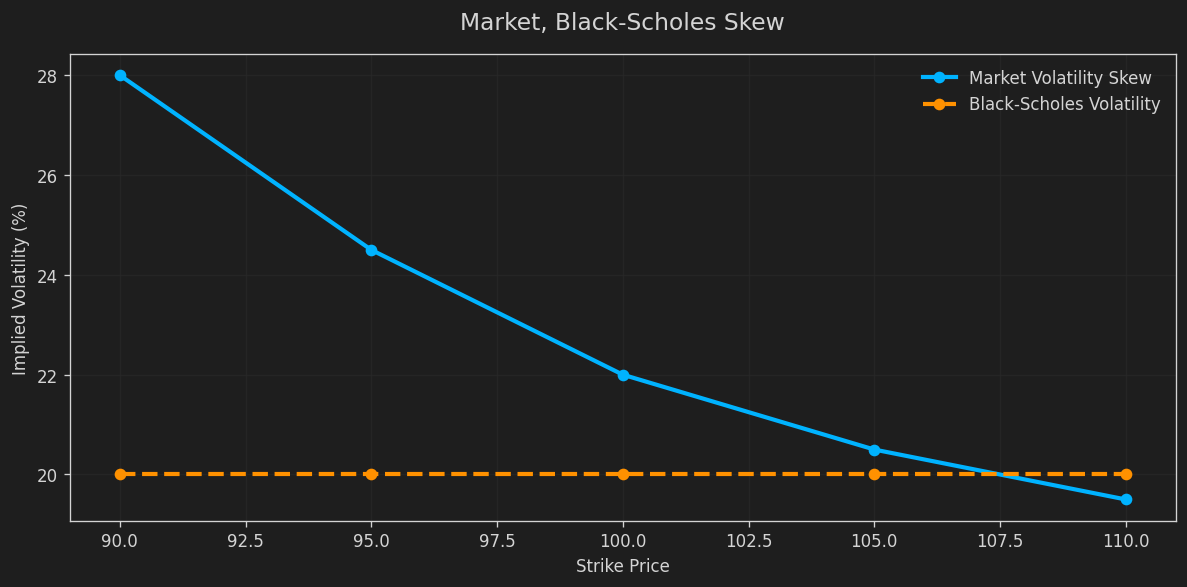

In [22]:
# Calculate skew relative to flat 20% BS vol
flat_bs_vol = 20.0
spot = 100


# Get market volatilities for each strike at each maturity
market_skew = market_vols[0]   # Take first maturity for simplicity
bs_skew = np.full_like(strikes, flat_bs_vol)

# --- Background style ---
bg      = "#1e1e1e"
fg      = "#d4d4d4"
gridcol = "#2a2a2a"

plt.rcParams.update({
    "figure.facecolor": bg,
    "axes.facecolor": bg,
    "axes.edgecolor": fg,
    "axes.labelcolor": fg,
    "xtick.color": fg,
    "ytick.color": fg,
    "text.color": fg,
    "grid.color": gridcol,
    "grid.alpha": 0.6,
})

# --- plot ---
fig, ax = plt.subplots(figsize=(10,5))

# Market skew line
ax.plot(strikes, market_skew, marker="o", color="#00b3ff", linewidth=2.5, label="Market Volatility Skew")

# Flat BS line
ax.plot(strikes, bs_skew, marker="o", color="#ff9100", linewidth=2.5, linestyle="--", label="Black-Scholes Volatility")

# Labels and title
ax.set_title("Market, Black-Scholes Skew", fontsize=14, pad=15)
ax.set_xlabel("Strike Price")
ax.set_ylabel("Implied Volatility (%)")

# Grid + legend
ax.grid(True)
ax.legend(loc="upper right", frameon=False)

plt.tight_layout()
plt.show()


## The Heston Model

The Black-Scholes model assumes a geometric Brownian motion stochastic differential equation for the underlying leading to the constant volatility assumption
$$\frac{dS_t}{S_t} = \mu dt + \sigma dW_t$$

To better match market prices and account for the volatility smile/skew, we can use the Heston Model:
$$\begin{align}
\frac{dS_t}{S_t} &= \mu dt + \sqrt{v_t} dW^1_t \\
dv_t &= \kappa(\theta - v_t)dt + \xi\sqrt{v_t}dW^2_t
\end{align}$$
- The variance follows a mean reverting stochastic process
- Adds correlation between spot and vol ($\rho dt = dW^1_t dW^2_t$)
- Better captures dynamics of implied volatility surface


Text(0, 0.5, 'Implied Volatility (%)')

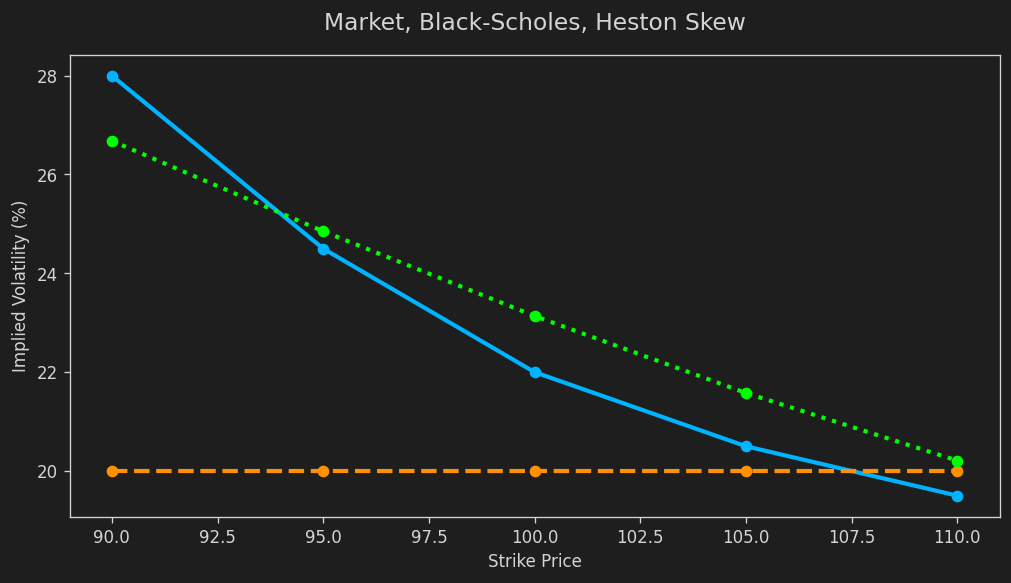

In [23]:
# Heston model parameters
kappa = 2.0  # Mean reversion speed
theta = .08  # Long-run variance
xi = 1.4  # Vol of vol
rho = -0.7  # Correlation
v0 = (flat_bs_vol/100)**2  # Initial variance

# Risk-free rate and time to maturity
r = 0.02
T = 1.0

# Simulation parameters
n_paths = 10000
n_steps = 252  # Daily steps
dt = T/n_steps


# Generate correlated Brownian motions
dW1 = np.random.normal(0, np.sqrt(dt), (n_paths, n_steps))
dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt), (n_paths, n_steps))

# Simulate Heston paths
S = np.zeros((n_paths, n_steps + 1))
v = np.zeros((n_paths, n_steps + 1))
S[:, 0] = spot
v[:, 0] = v0

for t in range(n_steps):
    v[:, t+1] = np.maximum(v[:, t] + kappa*(theta - v[:, t])*dt + xi*np.sqrt(v[:, t])*dW2[:, t], 0)
    S[:, t+1] = S[:, t] * np.exp((r - 0.5*v[:, t])*dt + np.sqrt(v[:, t])*dW1[:, t])

# Calculate Heston implied volatilities
heston_vols = []
for K in strikes:
    # Calculate call option prices
    payoffs = np.maximum(S[:, -1] - K, 0)
    heston_price = np.exp(-r*T) * np.mean(payoffs)
    
    # Find implied vol using Newton-Raphson
    def bs_price(sigma):
        d1 = (np.log(spot/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        return spot*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    
    def vega(sigma):
        d1 = (np.log(spot/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        return spot*np.sqrt(T)*norm.pdf(d1)
    
    sigma = flat_bs_vol/100  # Initial guess
    for _ in range(50):
        diff = bs_price(sigma) - heston_price
        if abs(diff) < 1e-5:
            break
        sigma = sigma - diff/vega(sigma)
    
    heston_vols.append(sigma*100)



# --- Background ---
bg      = "#1e1e1e"
fg      = "#d4d4d4"
gridcol = "#2a2a2a"

plt.rcParams.update({
    "figure.facecolor": bg,
    "axes.facecolor": bg,
    "axes.edgecolor": fg,
    "axes.labelcolor": fg,
    "xtick.color": fg,
    "ytick.color": fg,
    "text.color": fg,
    "grid.color": gridcol,
    "grid.alpha": 0.6,
})

# --- plot ---
fig, ax = plt.subplots(figsize=(10,5))

# Market skew line
ax.plot(strikes, market_skew, marker="o", color="#00b3ff", linewidth=2.5, label="Market Volatility Skew")

# add the BS flat line
ax.plot(strikes, bs_skew, marker="o", color="#ff9100", linewidth=2.5, linestyle="--", label="Black-Scholes Volatility")

# add the Heston skew line
ax.plot(strikes, heston_vols, marker="o", color="#00ff00", linewidth=2.5, linestyle=":", label="Heston Model Skew")

# Labels + title
ax.set_title("Market, Black-Scholes, Heston Skew", fontsize=14, pad=15)
ax.set_xlabel("Strike Price")
ax.set_ylabel("Implied Volatility (%)")


### Solve the Heston pricing expectation

Undet the Risk-Neutral measure, for the APT theorem, the price for European call option with strike K and maturity T is:
  $$C(S_t,v_t,t) = \mathbb{E}_t^\mathbb{Q}\left[e^{-r(T-t)}\max(S_T - K, 0)\right]$$
  where $S_T$ follows the Heston dynamics above. The expectation can be computed:
  1. Using Monte Carlo simulation of paths (stochastic processes simulation)
  2. Using semi-analytical Fourier methods with characteristic function: solve the characteristic function integral with FFT / COS
  3. Using Finite-Difference methods to solve the Heston PDE:
  $$\begin{align}
  \frac{\partial C}{\partial t} + \frac{1}{2}vS^2\frac{\partial^2 C}{\partial S^2} &+ \rho\xi vS\frac{\partial^2 C}{\partial S\partial v} + \frac{1}{2}\xi^2v\frac{\partial^2 C}{\partial v^2} \\
  &+ rS\frac{\partial C}{\partial S} + \kappa(\theta-v)\frac{\partial C}{\partial v} - rC = 0
  \end{align}$$

### Model Calibration

Once we determine *how* we will produce a price (Quasi-Closed-Form, Simulation, Numerical PDE)

We can go about finding the values of the parameters to use by calibrating our model to the market volatility surface

This is equivalent to solving the following minimization problem which yields the parameters to use:

$$\theta^* = argmin_{\theta \in \Theta} \delta (P^\mathcal{H}(\theta)), \mathcal{P}^{MKT})$$

Where $\delta$ is some measure of distance between the Heston model prices and the corresponding market prices (aka, it is the objective function to be minimized)


where $\theta^* = (\kappa, \theta, \xi, \rho, v_0$).

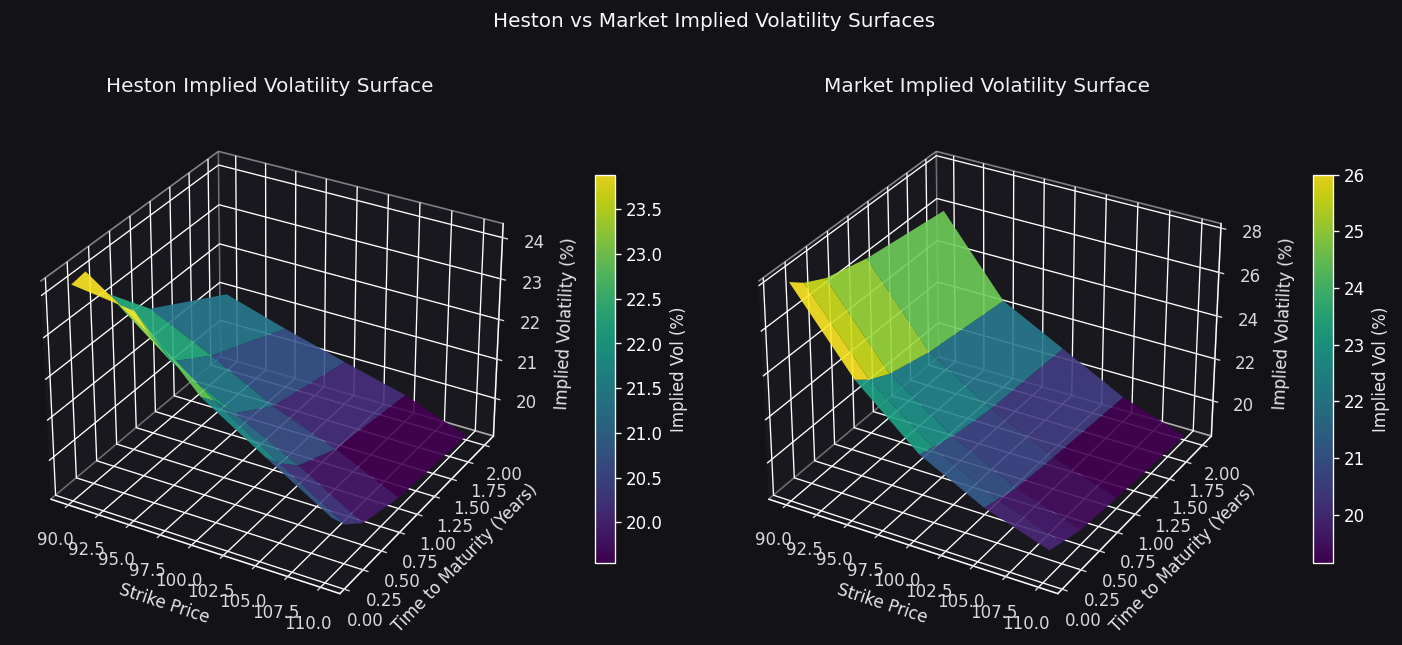

In [ ]:
# ==== DARK Background ====
plt.style.use('dark_background')

# Data for the volatility surface - precompute meshgrid
strikes = [90, 95, 100, 105, 110]
maturities = [1/12, 3/12, 6/12, 1, 2]    # in years
maturity_labels = ['1 Month', '3 Months', '6 Months', '1 Year', '2 Years']

# Market volatility values (in %)
market_vols = np.array([
    [28.0, 24.5, 22.0, 20.5, 19.5],  # 1 month
    [27.5, 24.0, 21.8, 20.3, 19.3],  # 3 months
    [27.0, 23.5, 21.5, 20.0, 19.0],  # 6 months
    [26.5, 23.0, 21.2, 19.8, 18.8],  # 1 year
    [26.0, 22.5, 21.0, 19.5, 18.5]   # 2 years
])

# Create meshgrid for 3D surface
X, Y = np.meshgrid(strikes, maturities)

def heston_paths(S0, v0, kappa, theta, xi, rho, r, T, N, M):
    """
    Simulate Heston paths using Euler discretization
    S0: initial stock price
    v0: initial variance
    kappa: mean reversion speed
    theta: long-run variance
    xi: volatility of variance
    rho: correlation
    r: risk-free rate
    T: time horizon
    N: number of time steps
    M: number of paths
    """
    dt = T/N
    
    # Initialize arrays
    S = np.zeros((N+1, M))
    v = np.zeros((N+1, M))
    S[0] = S0
    v[0] = v0
    
    # Generate correlated random numbers
    Z1 = np.random.standard_normal((N, M))
    Z2 = rho * Z1 + np.sqrt(1-rho**2) * np.random.standard_normal((N, M))
    
    # Simulate paths
    for i in range(N):
        # Ensure variance remains non-negative
        v[i+1] = np.maximum(v[i] + kappa*(theta - v[i])*dt + xi*np.sqrt(v[i]*dt)*Z1[i], 0)
        S[i+1] = S[i] * np.exp((r - 0.5*v[i])*dt + np.sqrt(v[i]*dt)*Z2[i])
    
    return S, v

def bs_implied_vol(S0, K, T, r, price, call=True):
    """Calculate BS implied volatility using Newton-Raphson"""
    def bs_price(sigma):
        # Black-Scholes price formula
        d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        if call:
            return S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
        else:
            return K*np.exp(-r*T)*norm.cdf(-d2) - S0*norm.cdf(-d1)
    
    sigma = 0.3  # Initial guess for volatility
    for _ in range(100): # Max 100 iterations for convergence
        price_diff = bs_price(sigma) - price
        if abs(price_diff) < 1e-5: # Convergence criterion
            return sigma
        d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        vega = S0*np.sqrt(T)*norm.pdf(d1) 
        if vega == 0: # Avoid division by zero
            return sigma
        sigma = sigma - price_diff/vega
        if sigma <= 0: # Ensure sigma remains positive
            sigma = 0.01
    return sigma # Return the best estimate if not converged

# Fixed parameters for plot
S0 = 100
v0 = 5.208/100  # Initial variance (converted from percentage)
kappa = 2.0
theta = 0.04
xi = 0.3
rho = -0.7
r = 0.02

# Calculate Heston implied volatility surface
heston_vols = np.zeros_like(market_vols)
N_paths = 100000 # Number of simulation paths

for i, T in enumerate(maturities):
    N_steps = int(T * 252)  # Daily steps (assuming 252 trading days in a year)
    if N_steps == 0: # Ensure at least one step for very short maturities
        N_steps = 1
    for j, K in enumerate(strikes):
        # Simulate paths
        S, v = heston_paths(S0, v0, kappa, theta, xi, rho, r, T, N_steps, N_paths)
        
        # Calculate option price (for a call option)
        payoffs = np.maximum(S[-1] - K, 0)
        price = np.exp(-r*T) * np.mean(payoffs)
        
        # Convert to implied vol
        try:
            impl_vol = bs_implied_vol(S0, K, T, r, price) * 100  # Convert to percentage
            heston_vols[i,j] = impl_vol
        except Exception as e:
            print(f"Could not calculate implied volatility for T={T}, K={K}: {e}")
            heston_vols[i,j] = np.nan # Assign NaN if calculation fails



# Create figure and 3D axes
fig = plt.figure(figsize=(12, 6), facecolor=(0.07, 0.07, 0.09))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf1 = ax1.plot_surface(X, Y, heston_vols, cmap='viridis', alpha=0.9, linewidth=0, antialiased=True)
surf2 = ax2.plot_surface(X, Y, market_vols, cmap='viridis', alpha=0.9, linewidth=0, antialiased=True)

# axes layout
for ax in (ax1, ax2):
    ax.set_facecolor((0.07, 0.07, 0.09))
    ax.xaxis.pane.set_facecolor((0.12, 0.12, 0.15, 1.0))
    ax.yaxis.pane.set_facecolor((0.12, 0.12, 0.15, 1.0))
    ax.zaxis.pane.set_facecolor((0.12, 0.12, 0.15, 1.0))
    ax.grid(color='0.3', linewidth=0.5)
    ax.tick_params(colors='0.85')
    for spine in ax.spines.values():
        spine.set_edgecolor('0.6')

# etichette e titoli
ax1.set_title('Heston Implied Volatility Surface', color='0.95', pad=12)
ax2.set_title('Market Implied Volatility Surface', color='0.95', pad=12)
ax1.set_xlabel('Strike Price', color='0.9')
ax1.set_ylabel('Time to Maturity (Years)', color='0.9')
ax1.set_zlabel('Implied Volatility (%)', color='0.9')
ax2.set_xlabel('Strike Price', color='0.9')
ax2.set_ylabel('Time to Maturity (Years)', color='0.9')
ax2.set_zlabel('Implied Volatility (%)', color='0.9')


# colorbar
cbar1 = fig.colorbar(surf1, ax=ax1, shrink=0.6, pad=0.1)
cbar2 = fig.colorbar(surf2, ax=ax2, shrink=0.6, pad=0.1)
cbar1.set_label('Implied Vol (%)', color='0.9')
cbar2.set_label('Implied Vol (%)', color='0.9')

plt.suptitle('Heston vs Market Implied Volatility Surfaces', color='0.98', y=0.97)
plt.tight_layout()
plt.savefig('iv_surfaces_dark.png', dpi=200, facecolor=fig.get_facecolor(), bbox_inches='tight')
plt.show()

# Exotic Pricing Functional Approximation

Let $B$ be the barrier level and $\tau$ be the first hitting time of $S_t$ to $B$
  
 For an up-and-out barrier option with maturity $T$:
  
 $V(S_0, v_0; \hat{\theta}) = \mathbb{E}^\mathbb{Q}\left[e^{-rT}(S_T - K)^+\mathbf{1}_{\{\tau > T\}} \mid S_0, v_0\right]$

 We can approximate the price of this price using Monte Carlo simulation.


In [25]:
def simulate_barrier_option(num_paths=1000, S0=100, K=100, B=120, T=1, r=0.05,
                            v0=0.04, kappa=2, theta=0.04, sigma=0.3, rho=-0.7):
    """
    Simulate up-and-out barrier option price using Heston model
    """
    dt = 1/252  # Daily steps
    N = int(T/dt)
    
    # Initialize arrays
    S = np.zeros((num_paths, N+1))
    v = np.zeros((num_paths, N+1))
    S[:, 0] = S0
    v[:, 0] = v0
    
    # Generate correlated random numbers
    Z1 = np.random.normal(0, 1, (num_paths, N))
    Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(0, 1, (num_paths, N))
    
    # Simulate paths
    for t in range(N):
        S[:, t+1] = S[:, t] * np.exp((r - 0.5*v[:, t])*dt + np.sqrt(v[:, t]*dt)*Z1[:, t])
        v[:, t+1] = np.maximum(v[:, t] + kappa*(theta - v[:, t])*dt + sigma*np.sqrt(v[:, t]*dt)*Z2[:, t], 0)
    
    # Calculate payoff (up-and-out barrier option)
    max_prices = np.maximum.accumulate(S, axis=1)
    barrier_not_hit = (max_prices[:, -1] < B)
    payoff = np.maximum(S[:, -1] - K, 0) * barrier_not_hit
    
    # Discount payoff
    price = np.exp(-r*T) * np.mean(payoff)
    
    return price, S

def plot_barrier_paths(S, B, K, price, num_display=100):
    """
    Plot sample paths with barrier level (dark mode for VS Code)
    """
    plt.style.use("dark_background")
    plt.figure(figsize=(12, 6))
    
    final_values = S[:, -1]
    max_values = np.maximum.accumulate(S, axis=1)[:, -1]
    barrier_hit = max_values >= B
    itm = final_values > K
    
    for i in range(min(len(S), num_display)):
        if barrier_hit[i]:
            plt.plot(S[i].T, color='red', alpha=0.2)
        elif itm[i]:
            plt.plot(S[i].T, color='lime', alpha=0.8)
        else:
            plt.plot(S[i].T, color='yellow', alpha=0.2)
    
    plt.axhline(y=B, color='red', linestyle='--', label='Barrier')
    plt.axhline(y=K, color='cyan', linestyle='--', label='Strike')
    plt.grid(True, alpha=0.3)
    plt.title(f'Sample Price Paths (N={len(S)}, Price=${price:.4f})', fontsize=14)
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

def barrier_option_widget():
    """
    Interactive widget for barrier option simulation
    """
    style = {'description_width': 'initial'}
    layout = widgets.Layout(width='400px')
    
    paths_slider = widgets.IntSlider(
        value=1000,
        min=10,
        max=10000,
        step=10,
        description='Number of Paths:',
        style=style,
        layout=layout
    )
    
    def update(paths):
        price, S = simulate_barrier_option(num_paths=paths)
        plot_barrier_paths(S, B=120, K=100, price=price)
    
    return widgets.interactive(update, paths=paths_slider)


display(barrier_option_widget())


interactive(children=(IntSlider(value=1000, description='Number of Paths:', layout=Layout(width='400px'), max=…

In [26]:
def simulate_vanilla_call(S0=100, K=100, r=0.05, sigma=0.2, T=1, num_paths=1000, num_steps=252):
    """
    Simulate vanilla call option price using Monte Carlo
    """
    dt = T/num_steps
    S = np.zeros((num_paths, num_steps+1))
    S[:, 0] = S0
    
    # Generate paths
    for t in range(num_steps):
        Z = np.random.standard_normal(num_paths)
        S[:, t+1] = S[:, t] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    # Calculate payoffs
    payoffs = np.maximum(S[:, -1] - K, 0)
    price = np.exp(-r * T) * np.mean(payoffs)
    
    return price, S

def plot_vanilla_paths(S, K=100, price=None, num_display=100):
    """
    Plot simulated price paths for vanilla call option (dark mode for VS Code)
    """
    plt.style.use("dark_background")
    plt.figure(figsize=(12, 6))
    
    # Plot only a subset for clarity
    for i in range(min(len(S), num_display)):
        if S[i, -1] > K:  # ITM paths
            plt.plot(S[i].T, color='lime', alpha=0.6)
        else:
            plt.plot(S[i].T, color='yellow', alpha=0.2)
    
    plt.axhline(y=K, color='cyan', linestyle='--', label='Strike')
    plt.grid(True, alpha=0.3)
    if price is not None:
        plt.title(f'Vanilla Call - Monte Carlo Paths (N={len(S)}, Price=${price:.4f})', fontsize=14)
    else:
        plt.title(f'Vanilla Call - Monte Carlo Paths (N={len(S)})', fontsize=14)
    
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

def vanilla_call_widget():
    """
    Create interactive widget for vanilla call option simulation
    """
    style = {'description_width': 'initial'}
    layout = widgets.Layout(width='400px')
    
    paths_slider = widgets.IntSlider(
        value=1000,
        min=10,
        max=10000,
        step=10,
        description='Number of Paths:',
        style=style,
        layout=layout
    )
    
    def update(paths):
        price, S = simulate_vanilla_call(num_paths=paths)
        plot_vanilla_paths(S, K=100, price=price)
    
    return widgets.interactive(update, paths=paths_slider)

# Display the interactive widget
display(vanilla_call_widget())


interactive(children=(IntSlider(value=1000, description='Number of Paths:', layout=Layout(width='400px'), max=…

#### <u>Price Adjustments</u>

After calculating the base exotic option price using our calibrated model, several adjustments are typically made:

 Counterparty Risk Adjustment
- Credit Value Adjustment (CVA) accounts for counterparty default risk
- Debt Value Adjustment (DVA) accounts for own default risk 
- These adjustments reduce the price when default risk is higher

Liquidity Adjustment  
- Exotic options are less liquid than vanilla options
- Wider bid-ask spreads reflect higher hedging costs
- Size of adjustment depends on:
  - Option complexity
  - Market conditions
  - Position size

Profit Margin
- Trading desks add profit margin to cover:
  - Operating costs
  - Capital charges
  - Return on equity requirements
- Typical margins range from 2-10% depending on:
  - Client relationship
  - Competition
  - Market conditions

The final quote sent to clients incorporates all these adjustments on top of the theoretical price.
 Let $Q$ be the final quote sent to clients. Then:

 $Q = P + CVA + DVA + L + M$

 where:
 - $P$ is the theoretical price from the calibrated model
 - $CVA$ is the credit value adjustment
 - $DVA$ is the debt value adjustment  
 - $L$ is the liquidity adjustment
 - $M$ is the profit margin